__Bipartite Graph Construction Based on Prototype:__
 * kmeans for prototyping ( select k prototypes)
 * construct Bipartite Graph based on Gaussian ( $ \sigma $ )
 * Laplacian and it's eigenvectors
 * new representation
 * test 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline

In [13]:
def generateTwoDisks():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)


    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Disks"

def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    x = np.zeros(200)
    y = np.zeros(200)
    label = np.zeros(200,dtype=int)
    x[:100], y[:100] = np.random.multivariate_normal(mean1, cov1, 100).T
    x[100:], y[100:] = np.random.multivariate_normal(mean2, cov2, 100).T
    label[100:] = np.ones(100)
    return x,y,label,"Gaussian"


def generateXOR():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    x = np.zeros(400)
    y = np.zeros(400)
    label = np.zeros(400,dtype=int)
    x[:100], y[:100] = np.random.multivariate_normal(mean1, cov1, 100).T
    x[100:200], y[100:200] = np.random.multivariate_normal(mean2, cov2, 100).T
#     label[100:200] = np.ones(100)
    
    
    mean3 = [2, -2]
    cov3 = [[1, 0], [0, 1]]  # diagonal covariance
    mean4 = [-2, 2]
    cov4 = [[1, 0], [0, 1]]  # diagonal covariance

    x[200:300], y[200:300] = np.random.multivariate_normal(mean3, cov3, 100).T
    x[300:], y[300:] = np.random.multivariate_normal(mean4, cov4, 100).T
    label[200:] = np.ones(200)
    
    return x,y,label,"XOR"

def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH,dtype=int)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Parabolas"


def plotData(x,y,label,dataName):
    plt.plot(x[label==0], y[label==0], 'bo')
    plt.plot(x[label==1], y[label==1], 'ro')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()
colors = ['b', 'g', 'r', 'w', 'y']
def plotData2(x,y,label,dataName):
    num = len(np.unique(sorted(label)))
    for i in range(num):
        plt.plot(x[label==i], y[label==i], colors[i%5]+'o')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()

<h2 style="color:red"> __Prototyping__ </h2>

In [4]:
def Prototyping(dataset,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(dataset)

    print 'initiated clustered data:'
    plotData2(X,Y,kmeans.labels_,'a')

    centers = kmeans.cluster_centers_
    return centers


<h2 style="color:red"> Graph Construction </h2>

In [45]:



def distance2(p1,p2):
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2
def similarity(p1,p2):
    sigma = 10
    return np.exp((-distance2(p1,p2)**2)/(2*(sigma**2)))


def constructBipartite(dataset,numS,centers,numP):
    N = numS + numP
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

def constructSupervised(dataset,numS,centers,numP,labels):
    labelNodes = np.unique(sorted(labels))
    p1 = np.sum(labelNodes)
    p0 = labels.shape[0] - p1
    P = [ 1.0/p0, 1.0/p1] 
    N = numS + numP + len(labelNodes)
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    for i in range(numS):
        W[i,numS+numP+labels[i]] = P[labels[i]]
        W[numS+numP+labels[i],i] = P[labels[i]]
    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

def constructSupervised2(dataset,numS,centers,numP,labels):
    labelNodes = np.unique(sorted(labels))
    p1 = np.sum(labelNodes)
    p0 = labels.shape[0] - p1
    P = [ 1.0/p0, 1.0/p1] 
    N = numS + numP + len(labelNodes)
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    for i in range(numS):
        W[i,numS+numP+labels[i]] = 1#P[labels[i]]
        W[numS+numP+labels[i],i] = 1#P[labels[i]]
    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

<h2 style="color:red">__unnormalized laplacian method (1)__</h2>

In [6]:
def unnormalized(W,D,L):
    # find eigenvectors and eigenvalues
    eigenValues , eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Shi & Malik (2)__</h2>

In [7]:
import scipy as sp
def normalized2(W,D,L):
    N = W.shape[0]
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    eigenValues , eigenVectors = sp.linalg.eig(L,D)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Ng & Jordan (2)__</h2>

In [8]:
def normalized3(W,D,L):
    N = W.shape[0]
    d = np.diag(D)
    d1 = 1/np.sqrt(d)
    D1 = np.diag(d1)
    Lsym = np.dot(np.dot(D1,L),D1)

    eigenValues , eigenVectors = np.linalg.eig(Lsym)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

In [50]:
def eigPlot(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    #1
    eig0 = (eigenVectors[:,0])[label == 0]
    eig1 = (eigenVectors[:,0])[label == 1]
    ax1.plot(range(len(eig0)),eig0,'bx')
    ax1.plot(range(len(eig0),N),eig1,'rx')
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    #2
    eig0 = (eigenVectors[:,1])[label == 0]
    eig1 = (eigenVectors[:,1])[label == 1]
    ax2.plot(range(len(eig0)),eig0,'bx')
    ax2.plot(range(len(eig0),N),eig1,'rx')
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)
    #3
    eig0 = (eigenVectors[:,2])[label == 0]
    eig1 = (eigenVectors[:,2])[label == 1]
    ax3.plot(range(len(eig0)),eig0,'bx')
    ax3.plot(range(len(eig0),N),eig1,'rx')
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)
    #4
    eig0 = (eigenVectors[:,3])[label == 0]
    eig1 = (eigenVectors[:,3])[label == 1]
    ax4.plot(range(len(eig0)),eig0,'bx')
    ax4.plot(range(len(eig0),N),eig1,'rx')
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)
    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()
    # 3,4
    xt = eigenVectors[:,2]
    yt = eigenVectors[:,3]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation 2 '+model)
    plt.savefig('new representation 2 '+model+'.jpg')
    plt.show()

    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

<h1 style="color:purple">__Results__</h2>

<h2 style="color:red">__Two Gaussian__</h2>

first data:


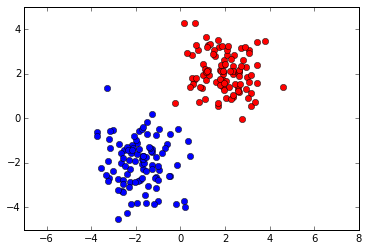

initiated clustered data:


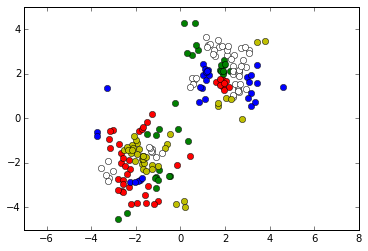

prototypes


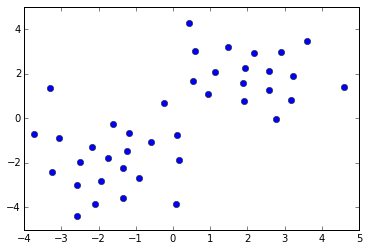

In [10]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoGaussian() #generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP


<h2 style="color:red">__Unnormalized Results__</h2>

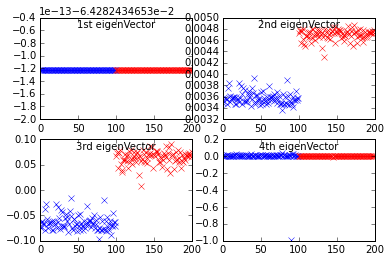

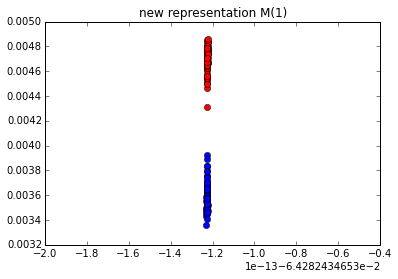

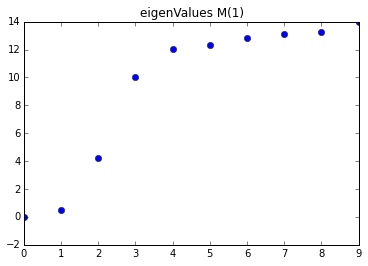

[ -9.92462615e-15   5.04312062e-01   4.20262882e+00   1.00176227e+01
   1.20547075e+01   1.23099337e+01   1.28553910e+01   1.31247166e+01
   1.32704983e+01   1.39782246e+01]


In [11]:
W,D,L = constructSupervised(dataset,numS,centers,numP,label)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

c:\Anaconda\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


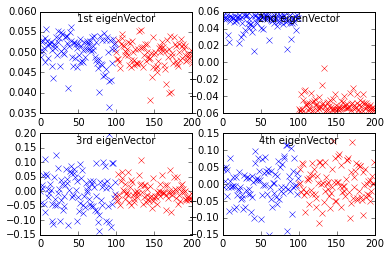

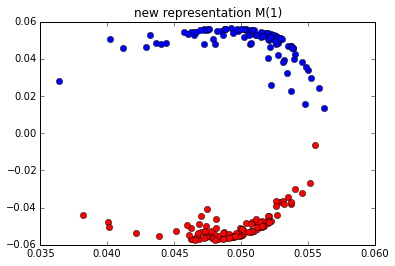

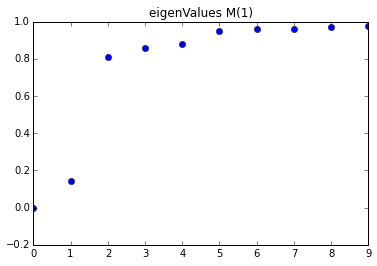

[ -3.66716770e-17   1.43126429e-01   8.12112863e-01   8.60705156e-01
   8.78778781e-01   9.50368849e-01   9.59932253e-01   9.62799552e-01
   9.69654716e-01   9.73927971e-01]


In [12]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Two Disks__</h2>


first data:


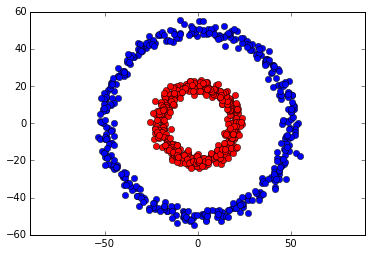

initiated clustered data:


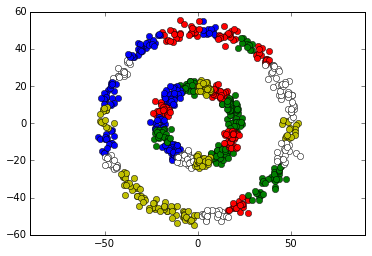

prototypes


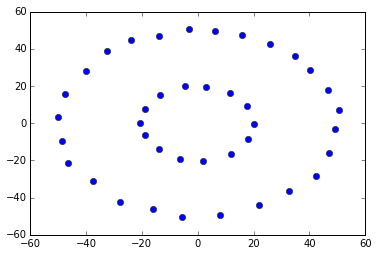

In [13]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>

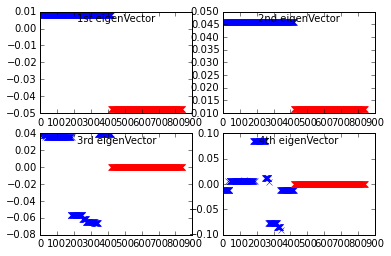

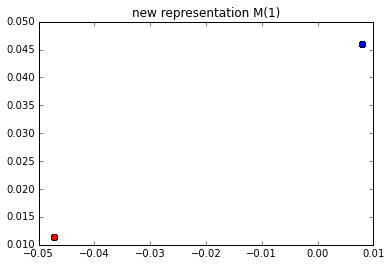

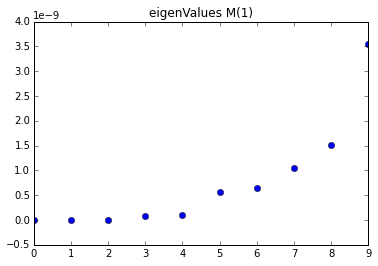

[ -1.72490871e-16  -2.97662792e-17   5.26649381e-12   8.93994480e-11
   1.07461909e-10   5.56518361e-10   6.54077848e-10   1.04581332e-09
   1.51387493e-09   3.55814079e-09]


In [14]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

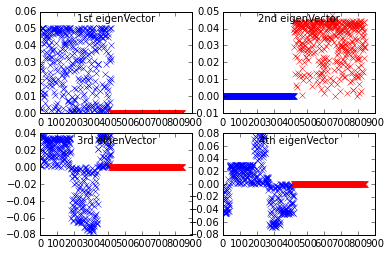

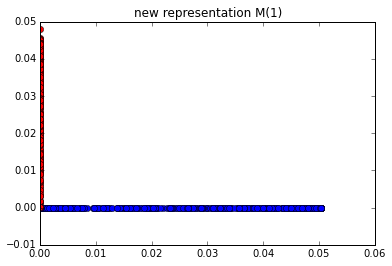

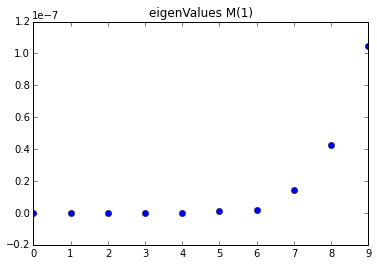

[ -5.54538151e-16  -5.12581438e-16   6.28995570e-12   1.11636892e-10
   1.17997178e-10   9.57385978e-10   2.02449850e-09   1.44843238e-08
   4.25475945e-08   1.04739876e-07]


In [15]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Two Parabolas__</h2>


first data:


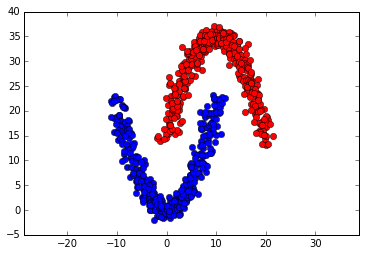

initiated clustered data:


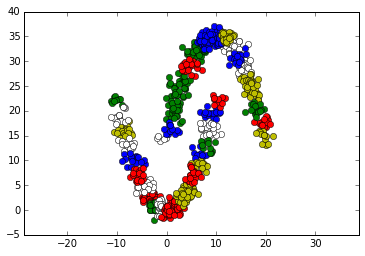

prototypes


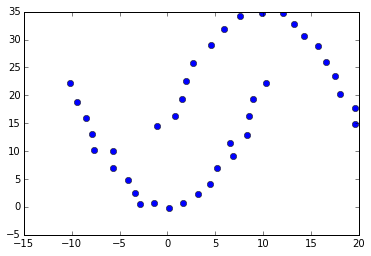

In [16]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoParabola()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>

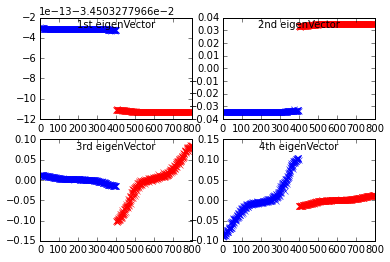

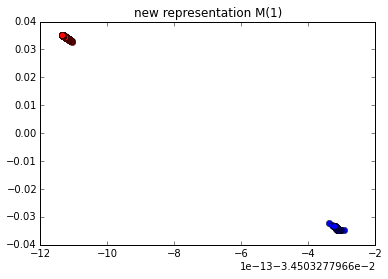

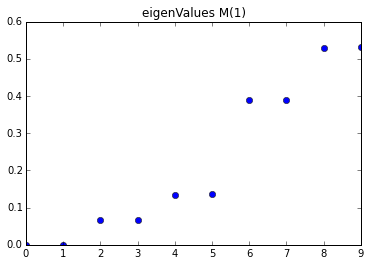

[  1.07880285e-14   6.60253605e-04   6.62190736e-02   6.75237999e-02
   1.33108144e-01   1.36194328e-01   3.88134818e-01   3.89024877e-01
   5.29006770e-01   5.30519646e-01]


In [17]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

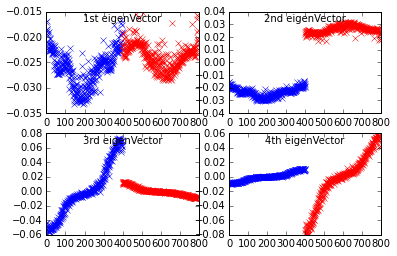

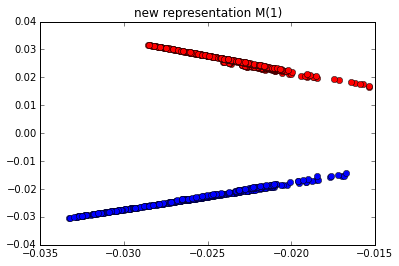

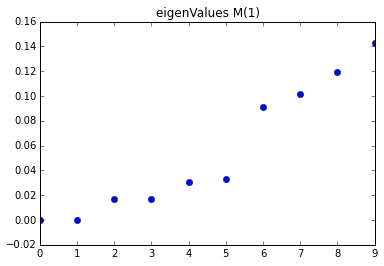

[ -4.05726204e-16   1.32090595e-04   1.69680558e-02   1.73064752e-02
   3.02435763e-02   3.28719446e-02   9.10831347e-02   1.01863686e-01
   1.19393048e-01   1.42913851e-01]


In [18]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

__idea:__
 * For new data we can use prototypes and NN 

<h2 style="color:red">__XOR__</h2>

first data:


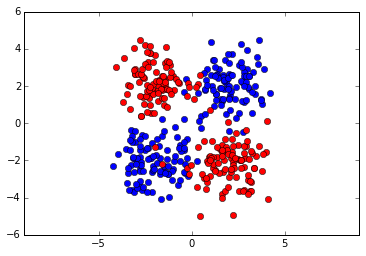

initiated clustered data:


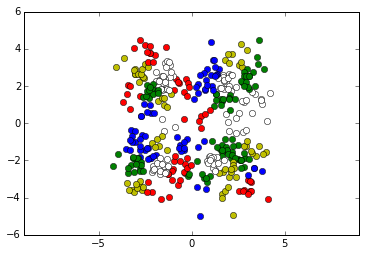

prototypes


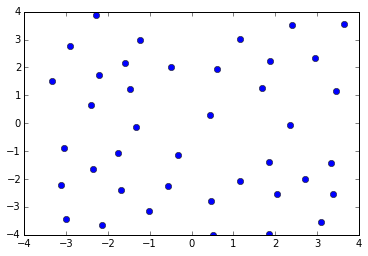

In [51]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateXOR() #generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>


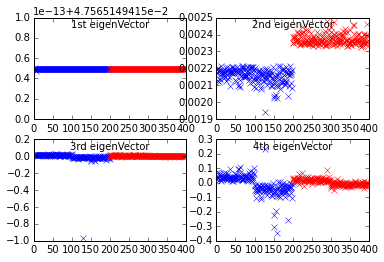

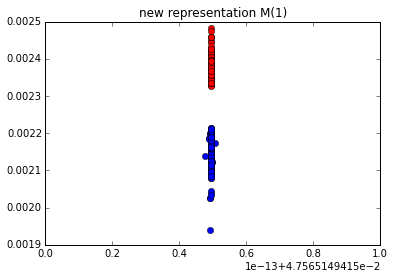

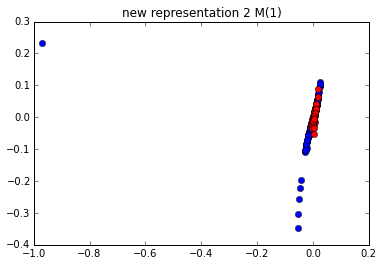

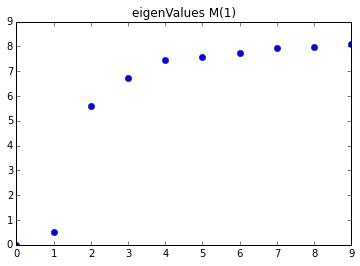

[  4.00790512e-14   5.02335294e-01   5.57792806e+00   6.70979108e+00
   7.46275833e+00   7.57871842e+00   7.74225124e+00   7.91919831e+00
   7.99106444e+00   8.10839566e+00]


In [52]:
W,D,L = constructSupervised(dataset,numS,centers,numP,label)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

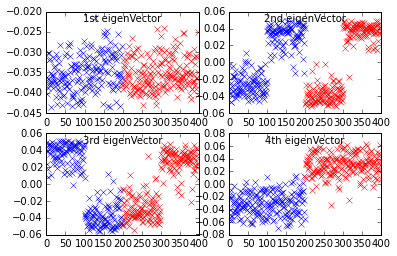

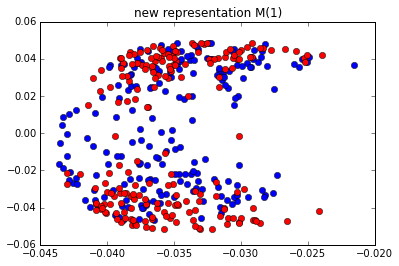

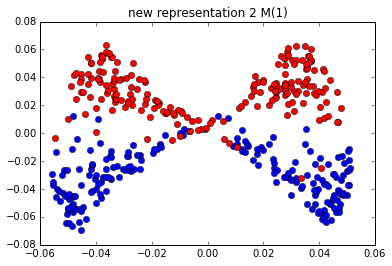

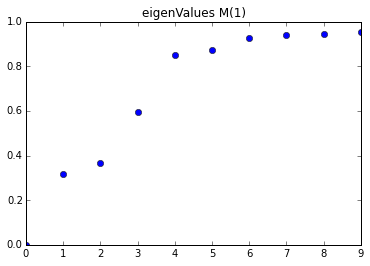

[  3.33066907e-15   3.15828230e-01   3.64944456e-01   5.94347603e-01
   8.48734556e-01   8.74839123e-01   9.25915007e-01   9.38349093e-01
   9.43646468e-01   9.53576814e-01]


In [53]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

In [62]:
import scipy.io as io
concentric = io.loadmat("Concentric_rings.mat")

In [66]:
concentric.keys()

['Y', 'X', '__version__', '__header__', '__globals__']

In [81]:
import scipy.io as io
def generateConcentric():
    concentric = io.loadmat("Concentric_rings.mat")
    x = concentric['X'][:,0]
    y = concentric['X'][:,1]
    label = concentric['Y'][:,0]
    label = (label==1)
    return x,y,label,"Concentric"

first data:


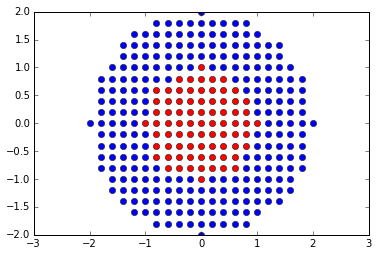

initiated clustered data:


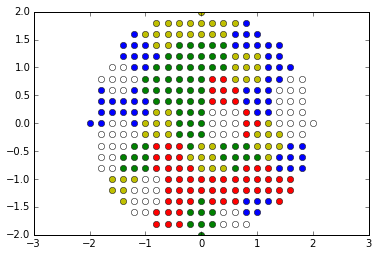

prototypes


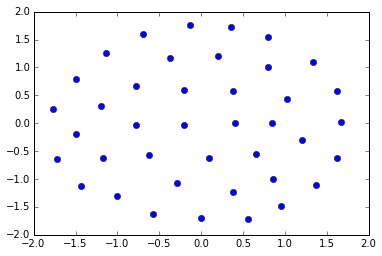

In [83]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateConcentric() #generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

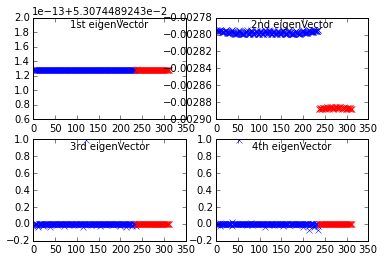

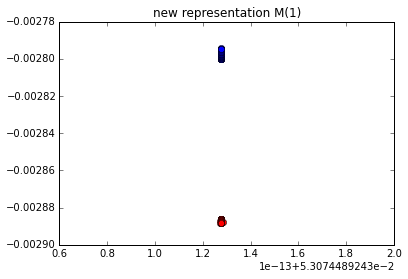

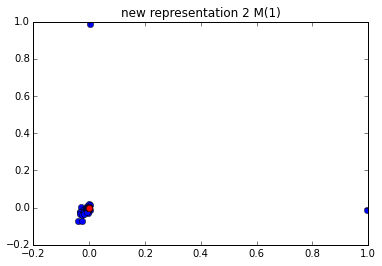

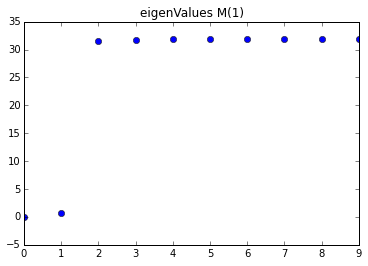

[ -2.53758008e-13   7.58529307e-01   3.15975900e+01   3.16916327e+01
   3.18041677e+01   3.18399902e+01   3.18464270e+01   3.18525970e+01
   3.18656657e+01   3.18837958e+01]


In [84]:
W,D,L = constructSupervised(dataset,numS,centers,numP,label)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

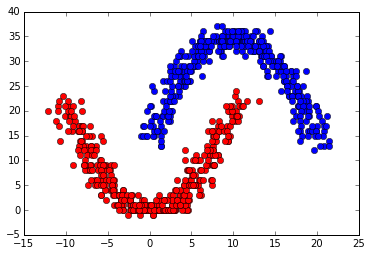

NameError: name 'wineY' is not defined

In [20]:
wineX

NameError: name 'wineX' is not defined